In [1]:
!pip install comet_ml > /dev/null 2>&1

In [2]:
!pip install mitdeeplearning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!apt-get install abcmidi timidity > /dev/null 2>&1

In [4]:
import comet_ml
import tensorflow as tf
import mitdeeplearning as mdl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import functools
import IPython
import functools
from tqdm import tqdm


In [19]:
COMET_API_KEY = 'ZNDtlXJzHWLWKfA7YIgwsZGWV'

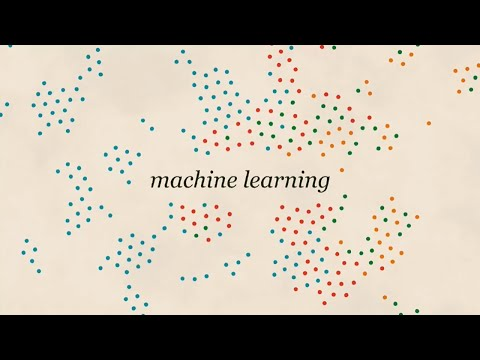

In [5]:
IPython.display.YouTubeVideo('59bMh59JQDo')

#Dataset

In [6]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 [==============================] - 30s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [9]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

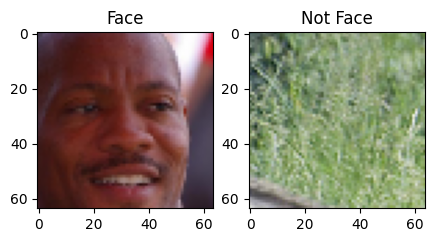

In [16]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 26 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 17 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

#CNN

In [17]:
n_filters = 12


def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [20]:
def create_experiment(project_name, params):
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name=project_name)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

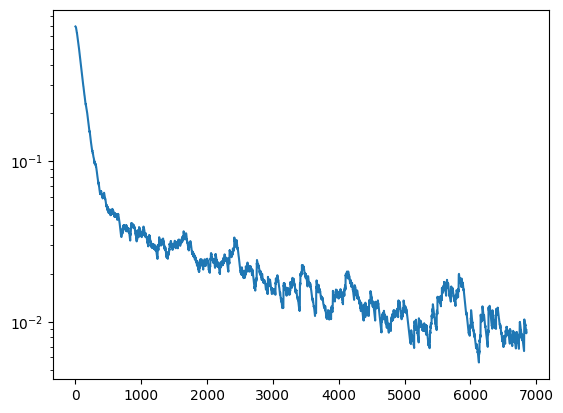

100%|██████████| 3434/3434 [04:45<00:00, 12.02it/s]


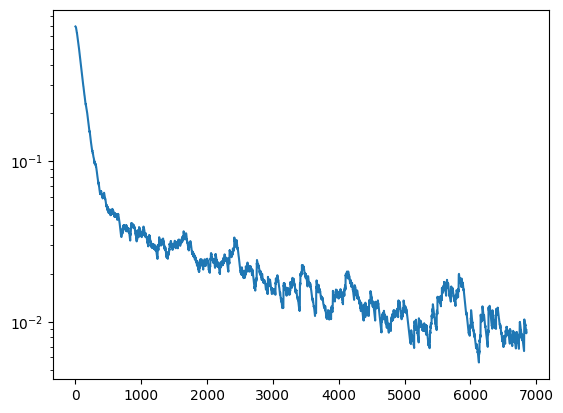

In [21]:
params = dict(
  batch_size = 32,
  num_epochs = 2,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("CNN_CV_DL_LAB2", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(params["batch_size"])
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [22]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 4s 19ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9970


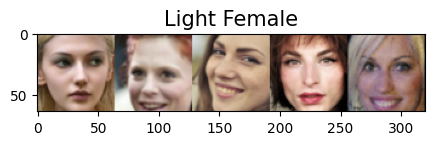

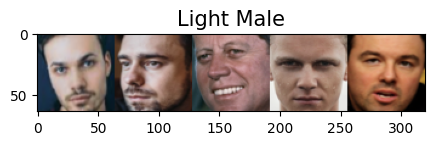

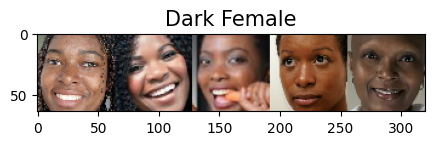

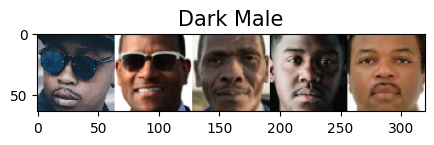

In [23]:
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Text(0.5, 1.0, 'Standard classifier predictions')

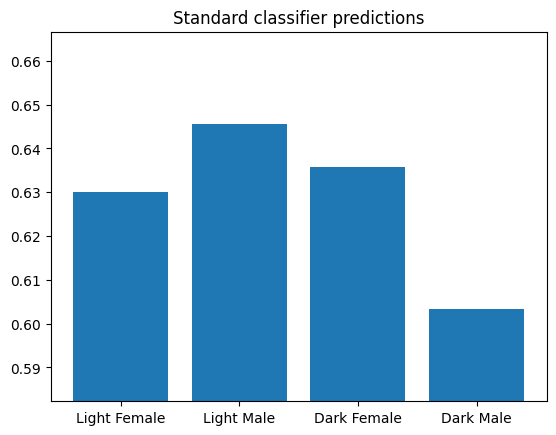

In [24]:
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions")

In [25]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon

  return z

In [27]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):


  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)


  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )


  return total_loss, classification_loss

In [28]:
n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [29]:
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim


    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):

    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):

    reconstruction = self.decoder(z)

    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)


    z = self.reparameterize(z_mean, z_logsigma)



    recon = self.decode(z)

    return y_logit, z_mean, z_logsigma, recon


  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)


In [30]:
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [31]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")


    mu = get_latent_mu(images, dbvae)

    training_sample_p = np.zeros(mu.shape[0])

    for i in range(latent_dim):

        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)


        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function
        p = 1.0/(hist_smoothed_density[bin_idx-1])


        p = p / np.sum(p)

        training_sample_p = np.maximum(p, training_sample_p)


    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p


Starting epoch 1/1
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

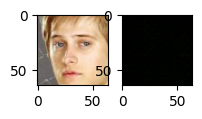

 15%|█▍        | 500/3434 [01:15<05:41,  8.60it/s]

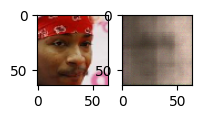

 29%|██▉       | 1000/3434 [02:23<04:46,  8.48it/s]

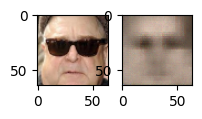

 44%|████▎     | 1500/3434 [03:36<04:07,  7.82it/s]

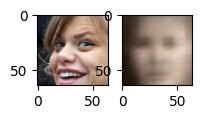

 58%|█████▊    | 2000/3434 [04:44<04:37,  5.17it/s]

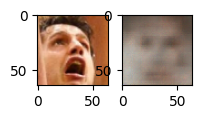

 73%|███████▎  | 2500/3434 [05:55<03:18,  4.71it/s]

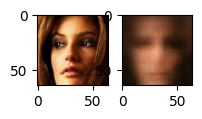

 87%|████████▋ | 3000/3434 [07:03<00:49,  8.74it/s]

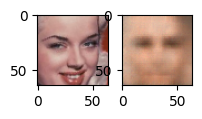

100%|██████████| 3434/3434 [08:06<00:00,  7.06it/s]
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : existing_dome_6692
COMET INFO:     url                   : https://www.comet.com/itskindastrange/6s191-lab2-part2-dbvae/a3323301152b428d8788ab91987403da
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3434] : (0.057877540588378906, 0.9378196597099304)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue          

In [32]:
params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  num_epochs = 1, #DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)


    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)


  grads = tape.gradient(loss, dbvae.trainable_variables)

  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss


all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))

  # Recompute data sampling proabilities
  p_faces = get_training_sample_probabilities(all_faces, dbvae)


  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()


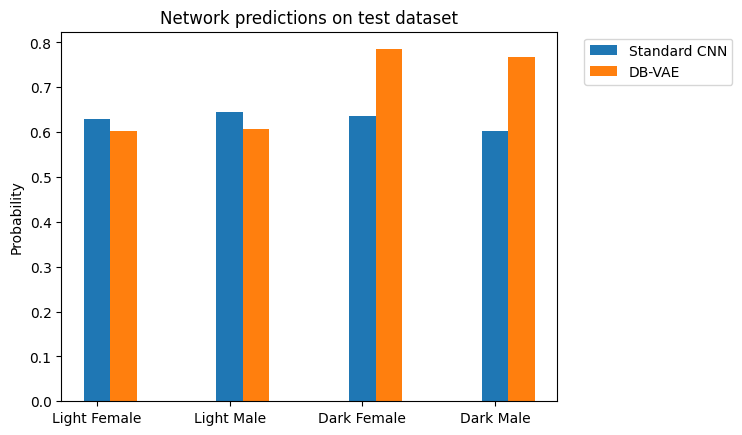

In [33]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys);
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");


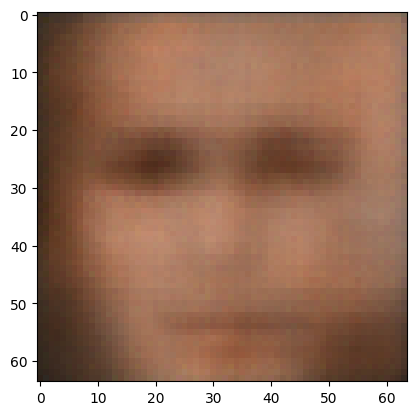

In [41]:

import matplotlib.pyplot as plt
# Generate a random latent vector
z = tf.random.normal(shape=(10, latent_dim))

# Decode the latent vector into an image
generated_image = dbvae.decode(z)

# Display the generated image
plt.imshow(generated_image[0])
plt.show()
